# Logical magic state distillation

In [1]:
import stim
import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
from bloqade.squin import kernel
from bloqade import squin
from bloqade.tsim import Circuit

In this tutorial, we will perform quantum circuit simulations with squin kernels. We will simulate the magic state distillation circuit used in [Rodriguez et al. (2025)](https://www.nature.com/articles/s41586-025-09367-3), showcasing that `bloqade-circuit` supports simulation of large non-Clifford circuits. For this, we will use Quera's TSIM package as a simulation backend.

### Magic states

We start by preparing a particular magic state, the eigenstate of the "SH" operator. To simulate noise, we add a depolarizing channel after state preparation:

In [2]:
theta = -np.arccos(np.sqrt(1 / 3))  # Distillation angle
p = 0.05  # Noise probability


@kernel
def main():
    q = squin.qalloc(1)
    squin.reset(q[0])
    squin.rx(angle=theta, qubit=q[0])
    squin.t_adj(qubit=q[0])
    squin.depolarize(p=p, qubit=q[0])


Circuit(main).diagram(height=120)

By undoing the state preparation after the noisy channel, we build a kernel that measures the fidelity of the magic state:

In [3]:
@kernel
def main():
    q = squin.qalloc(1)
    squin.reset(q[0])
    squin.rx(angle=theta, qubit=q[0])
    squin.t_adj(qubit=q[0])
    squin.depolarize(p=p, qubit=q[0])
    squin.t(qubit=q[0])
    squin.rx(angle=-theta, qubit=q[0])
    squin.measure(q[0])

c = Circuit(main)
c.diagram(height=120)

We simulate the circuit as follows:

In [4]:
sampler = c.compile_sampler()
samples = sampler.sample(shots=100_000)
print(f"Infidelity: {np.count_nonzero(samples) / len(samples)}")

Infidelity: 0.03259


The noisy state preparation process (modeled by a single `squin.depolarize` gate), leads to a magic state with 97% fidelity.


### Magic state distillation: The ideal case

Given multiple noisy magic states of low fidelity, we can distill a single high-fidelity magic state using a distillation circuit:

In [5]:
def make_logical_distillation_kernel(angle: float, p: float):
    @kernel
    def distillation():
        q = squin.qalloc(5)

        # initial state - prepare noisy magic states on all 5 qubits
        squin.broadcast.reset(q)
        squin.broadcast.rx(angle, q)
        squin.broadcast.t_adj(q)
        squin.broadcast.depolarize(p, q)

        # # distillation circuit
        squin.broadcast.sqrt_x([q[0], q[1], q[4]])
        squin.broadcast.cz([q[0], q[2]], [q[1], q[3]])
        squin.broadcast.sqrt_y([q[0], q[3]])
        squin.broadcast.cz([q[0], q[3]], [q[2], q[4]])
        squin.broadcast.sqrt_x_adj([q[0]])
        squin.broadcast.cz([q[0], q[1]], [q[4], q[3]])
        squin.broadcast.sqrt_x_adj(q)

        # # undo magic state preparation on first qubit to measure infidelity
        squin.t(qubit=q[0])
        squin.rx(angle=-angle, qubit=q[0])

        squin.broadcast.measure(q)

    return distillation


distillation_kernel = make_logical_distillation_kernel(theta, p)
c = Circuit(distillation_kernel)
c.diagram(height=240)

In this distillation circuit, qubits `[q1,q2,q3,q4]` are the distillation syndrome. 
If we measure them in the state `[1,0,1,1]`, we know that distillation was successful and the first qubit `q0` is in a magic state with higher fidelity.

To measure the fidelity, we undo the magic state preparation on the first qubit before measurement.

In [6]:
samples = c.compile_sampler().sample(shots=10_000, batch_size=10_000)

def post_select(samples: np.ndarray):
    distilled_output = samples[:, 0]
    distillation_syndromes = samples[:, 1:]
    sel = np.all(distillation_syndromes == np.array([1, 0, 1, 1]), axis=1)
    return distilled_output[sel]


post_selected_samples = post_select(samples)
print(
    f"Infidelity: {np.count_nonzero(post_selected_samples) / len(post_selected_samples):.5f}"
)
print(
    f"Percentage of post-selected samples: {len(post_selected_samples) / len(samples) * 100:.2f}%"
)

Infidelity: 0.00956
Percentage of post-selected samples: 14.64%


After distillation, the fidelity has increased to 99.7%. This is much better than the original 97% of the individual input magic states. A downside is that the distillation process is only successful 13.7% of the time. This means, we have to repeat the distillation process multiple times until we get a good output state.

We can study other properties of the distillation circuit. For example, we analyze the dependence of the fidelity on the rotation angle of the RX gate:

In [7]:
angles = np.linspace(-0.4, 0.4, 7) + theta
fidelities = []
post_selection_rate = []
for angle in angles:
    distillation_kernel = make_logical_distillation_kernel(angle, p)
    c = Circuit(distillation_kernel)
    samples = c.compile_sampler(seed=0).sample(shots=4_096)

    post_selected_samples = post_select(samples)
    post_selection_rate.append(len(post_selected_samples) / len(samples))
    f = np.count_nonzero(post_selected_samples) / len(post_selected_samples)
    fidelities.append(1 - f)

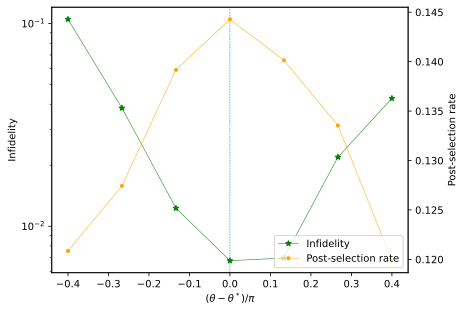

In [ ]:
fig, ax1 = plt.subplots()

(line1,) = ax1.semilogy(angles - theta, 1 - np.array(fidelities), "*-", c="g", lw=0.5, label="Infidelity")
ax1.axvline(0, linestyle="--", lw=0.5)
ax1.set_xlabel(r"$(\theta - \theta^*)/\pi$")
ax1.set_ylabel("Infidelity")

ax2 = ax1.twinx()
(line2,) = ax2.plot(angles - theta, post_selection_rate, ".-", c="orange", lw=0.5, label="Post-selection rate")
ax2.set_ylabel("Post-selection rate")
ax2.legend(handles=[line1, line2], loc="lower right");

We see that the output fidelity and post-selection rate are peaked at the distillation angle $\theta^*$. This is expected, as the distillation circuit is designed to distill only one particular state.

### Magic state distillation: The realistic case (with noise)

On a real quantum computer, the distillation circuit is noisy itself. Here, the benefit of distillation is
generally outweighed by the noise in the distillation circuit.

We can explicitly see this using a simulation, where we add noise to the distillation circuit. Note that we consider two different noise scales:
- `p` is the noise that captures the magic state preparation process.
- `noise` is the noise strength of the depolarizing noise in the distillation circuit.


In [9]:
noise = p / 5

@kernel
def noisy_distillation():
    q = squin.qalloc(5)

    # initial state - prepare noisy magic states on all 5 qubits
    squin.broadcast.reset(q)
    squin.broadcast.rx(angle, q)
    squin.broadcast.t_adj(q)
    squin.broadcast.depolarize(p, q)

    # distillation circuit
    squin.broadcast.depolarize(noise, q)
    squin.broadcast.sqrt_x([q[0], q[1], q[4]])
    squin.broadcast.depolarize(noise, [q[0], q[1], q[4]])
    squin.broadcast.cz([q[0], q[2]], [q[1], q[3]])
    squin.broadcast.depolarize2(noise, [q[0], q[2]], [q[1], q[3]])
    squin.broadcast.sqrt_y([q[0], q[3]])
    squin.broadcast.depolarize(noise, [q[0], q[3]])
    squin.broadcast.cz([q[0], q[3]], [q[2], q[4]])
    squin.broadcast.depolarize2(noise, [q[0], q[3]], [q[2], q[4]])
    squin.broadcast.sqrt_x_adj([q[0]])
    squin.broadcast.depolarize(noise, [q[0]])
    squin.broadcast.cz([q[0], q[1]], [q[4], q[3]])
    squin.broadcast.depolarize2(noise, [q[0], q[1]], [q[4], q[3]])
    squin.broadcast.sqrt_x_adj(q)
    squin.broadcast.depolarize(noise, q)

    # undo magic state preparation on first qubit to measure infidelity
    squin.t(qubit=q[0])
    squin.rx(angle=-angle, qubit=q[0])

    squin.broadcast.measure(q)

In [10]:
c = Circuit(noisy_distillation)
samples = c.compile_sampler(seed=0).sample(shots=40_000, batch_size=40_000)

def post_select(samples: np.ndarray):
    distilled_output = samples[:, 0]
    distillation_syndromes = samples[:, 1:]
    sel = np.all(distillation_syndromes == np.array([1, 0, 1, 1]), axis=1)
    return distilled_output[sel]


post_selected_samples = post_select(samples)
print(f"Infidelity: {np.count_nonzero(post_selected_samples) / len(post_selected_samples):.5f}")
print(f"Percentage of post-selected samples: {len(post_selected_samples) / len(samples) * 100:.2f}%")

Infidelity: 0.08333
Percentage of post-selected samples: 10.98%


We see that the addition of noise has reduced the output fidelity to ~92%. This is worse than the input state!

# Encoding the distillation circuit

To address this issue, we need to make our distillation circuit resilient to noise.
We do this by encoding it using a quantum error correction code, specifically the [17,1,5] color code.

The following kernel takes a physical qubit with an arbitrary state at qubit `q[7]` and returns a logical qubit in the same (but now logical) state as `q[7]`:

In [11]:
@kernel
def encode(q):
    squin.broadcast.reset([q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16]])
    squin.broadcast.sqrt_y([q[0], q[1], q[2], q[3], q[4], q[5], q[6], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16]])
    squin.broadcast.cz([q[1], q[7], q[12], q[13]], [q[3], q[10], q[14], q[16]])
    squin.broadcast.sqrt_y_adj([q[7], q[16]])
    squin.broadcast.cz([q[4], q[8], q[11], q[15]], [q[7], q[10], q[14], q[16]])
    squin.broadcast.sqrt_y_adj([q[4], q[10], q[14], q[16]])
    squin.broadcast.cz([q[2], q[6], q[7], q[10], q[14]], [q[4], q[8], q[9], q[13], q[16]])
    squin.broadcast.sqrt_y([q[3], q[6], q[9], q[10], q[12], q[13]])
    squin.broadcast.cz([q[0], q[3], q[5], q[10], q[11]], [q[2], q[6], q[8], q[12], q[13]])
    squin.broadcast.sqrt_y([q[1], q[2], q[3], q[4], q[6], q[7], q[8], q[9], q[11], q[12], q[14]])
    squin.broadcast.cz([q[0], q[2], q[4], q[6], q[8], q[12]], [q[1], q[3], q[5], q[7], q[9], q[15]])
    squin.broadcast.sqrt_y_adj([q[0], q[2], q[5], q[6], q[8], q[10], q[12]])
    squin.broadcast.x([q[14], q[7], q[5], q[2], q[1], q[4]])
    squin.broadcast.z([q[11], q[6], q[4], q[2]])

In [12]:
@kernel
def main():
    q = squin.qalloc(17)
    encode(q)
c = Circuit(main)
c.diagram(height=400)

While the encoding kernel may look complex, we can verify its correctness by checking its stabilizer flow:

In [13]:
stim.Circuit(str(c)).flow_generators()

[stim.Flow("1 -> ____________X_XXX"),
 stim.Flow("1 -> ____________Z_ZZZ"),
 stim.Flow("1 -> ___________X_XX_X"),
 stim.Flow("1 -> ___________Z_ZZ_Z"),
 stim.Flow("1 -> __________X__XXX_"),
 stim.Flow("1 -> __________Z__ZZZ_"),
 stim.Flow("1 -> ______XXXX_______"),
 stim.Flow("1 -> ______ZZZZ_______"),
 stim.Flow("1 -> ____XX__XX_______"),
 stim.Flow("1 -> ____ZZ__ZZ_______"),
 stim.Flow("1 -> __XX_X_X_X___X_XX"),
 stim.Flow("1 -> __ZZ_Z_Z_Z___Z_ZZ"),
 stim.Flow("1 -> _X_X____XX_______"),
 stim.Flow("1 -> _Z_Z____ZZ_______"),
 stim.Flow("1 -> X__X_X_XX____X_XX"),
 stim.Flow("1 -> Z__Z_Z_ZZ____Z_ZZ"),
 stim.Flow("_______X_________ -> ________XX___X_XX"),
 stim.Flow("_______Z_________ -> ________ZZ___Z_ZZ")]

The encoding kernel takes an arbitrary input state at `q[7]`. The physical Pauli operators of this qubit are encoded into logical operators of the [17,1,5] code: $X_8X_9 X_{13} X_{15}X_{16}$ (`________XX___X_XX`) and $Z_8Z_9Z_{13}Z_{15}Z_{16}$ (`________ZZ___Z_ZZ`).

Additionally, the stabilizer flow shows the 16 stabilizer generators that stabilize the output state.

## The fully encoded protocol

Now we are ready to construct the full kernel of the encoded distillation experiment. This will be a kernel with 85 qubits (5 logical qubits, constructed from 17 physical qubits each).

Let us summarize the protocol we are going to simulate:
- **Prepare 5 encoded magic states at 97% fidelity.** The input magic states are noisy, and we assume the encoding process to be noiseless. While this is a simplification for this tutorial, it does not introduce any qualitative changes. We can think of this as an abstract preparation protocol that produces 5 encoded magic states, each with 97% fidelity.
- **Distill 5 encoded magic states into a single logical qubit.** We use a transversal encoding of the distillation circuit we studied above. We will also add full circuit-level noise.
- **Perform post-selection** We will perform two stages of post-selection: (a) post-select on the perfect stabilizers, and (b) post-select on the [1,0,1,1] distillation syndrome of logical bits.
- **Quantum state tomography** We will perform quantum state tomography on the output logical qubit to estimate its magic state fidelity.

In [14]:
@kernel
def measure_and_annotate(q, idx):
    m = squin.broadcast.measure(q)
    squin.set_detector([m[0], m[1], m[2], m[3]], coordinates=[0])
    squin.set_detector([m[0], m[2], m[4], m[5]], coordinates=[1])
    squin.set_detector([m[4], m[5], m[6], m[7]], coordinates=[2])
    squin.set_detector([m[6], m[7], m[8], m[9]], coordinates=[3])
    squin.set_detector([m[11], m[13], m[14], m[16]], coordinates=[4])
    squin.set_detector([m[10], m[11], m[12], m[14]], coordinates=[5])
    squin.set_detector([m[12], m[14], m[15], m[16]], coordinates=[6])
    squin.set_detector([m[2], m[3], m[5], m[6], m[8], m[10], m[11], m[13]], coordinates=[7])
    squin.set_observable([m[1], m[3], m[10], m[12], m[15]], idx=idx)

In [15]:
def make_encoded_distillation_kernel(
    basis: Literal["X", "Y", "Z"], p_prep: float, noise: float = 0.0
):
    @kernel
    def encoded_distillation():
        q = squin.qalloc(85)
        q0 = q[:17]
        q1 = q[17:34]
        q2 = q[34:51]
        q3 = q[51:68]
        q4 = q[68:85]
        qs = [q0, q1, q2, q3, q4]

        # Initialize: prepare noisy magic states on all logical qubits (transversally)
        for i in range(5):
            squin.rx(theta, q[7 + i*17])
            squin.t_adj(q[7 + i*17])
            squin.depolarize(p_prep, q[7 + i*17])
            encode(qs[i])

        # Distillation circuit with transversal gates and noise
        squin.broadcast.sqrt_x(q0 + q1 + q4)
        squin.broadcast.depolarize(noise, q0 + q1 + q4)

        squin.broadcast.cz(q0 + q2, q1 + q3)
        squin.broadcast.depolarize2(noise, q0 + q2, q1 + q3)

        squin.broadcast.sqrt_y(q0 + q3)
        squin.broadcast.depolarize(noise, q0 + q3)

        squin.broadcast.cz(q0 + q3, q2 + q4)
        squin.broadcast.depolarize2(noise, q0 + q3, q2 + q4)

        squin.broadcast.sqrt_x_adj(q0)
        squin.broadcast.depolarize(noise, q0)

        squin.broadcast.cz(q0 + q1, q4 + q3)
        squin.broadcast.depolarize2(noise, q0 + q1, q4 + q3)

        squin.broadcast.sqrt_x_adj(q0 + q1 + q2 + q3 + q4)
        squin.broadcast.depolarize(noise, q0 + q1 + q2 + q3 + q4)

        # Basis rotation for measurement on logical qubit 0
        if basis == "X":
            squin.broadcast.h(q0)
        elif basis == "Y":
            squin.broadcast.s_adj(q0)
            squin.broadcast.h(q0)

        # Readout: measurements and detector and observable annotations
        for i in range(5):
            measure_and_annotate(qs[i], i)

    return encoded_distillation


encoded_kernel = make_encoded_distillation_kernel("Z", p_prep=p, noise=p / 10)
encoded_circuit = Circuit(encoded_kernel)
encoded_circuit.diagram(height=500)

We will perform quantum state tomography on the first logical qubit to estimate its magic state fidelity. For this, we will simulate three different versions of the circuit, where the first logical qubit is measured in the $X$, $Y$, and $Z$ basis, respectively.

Then, we will perform two stages of post-selection:
- First, post-select all shots on perfect stabilizers (i.e. only keep shots where all detectors are measured as 0)
- Then, post-select on the [1,0,1,1] distillation syndrome.

In [16]:
def sample_and_post_select(encoded_kernel, shots: int = 10_000):
    c = Circuit(encoded_kernel)
    sampler = c.compile_detector_sampler(seed=1)
    det_samples, obs_samples = sampler.sample(
        shots=shots, batch_size=shots, separate_observables=True
    )

    # post-select on perfect stabilizers
    perfect_stabilizers = np.all(det_samples == 0, axis=1)
    obs_samples = obs_samples[perfect_stabilizers]

    # post-select on the [1,0,1,1] distillation syndrome of logical bits
    post_selected_observables = post_select(obs_samples)
    p1 = np.count_nonzero(post_selected_observables) / len(post_selected_observables)
    eval = 1 - 2 * p1
    print(
        f"Expectation value: {eval:.4f}, percentage kept: {len(post_selected_observables) / shots * 100:.2f}%"
    )
    return eval

In [17]:
kernel_x = make_encoded_distillation_kernel("X", p, p / 5)
kernel_y = make_encoded_distillation_kernel("Y", p, p / 5)
kernel_z = make_encoded_distillation_kernel("Z", p, p / 5)

vx = sample_and_post_select(kernel_x, shots=100_000)
vy = sample_and_post_select(kernel_y, shots=100_000)
vz = sample_and_post_select(kernel_z, shots=100_000)

Expectation value: 0.5535, percentage kept: 1.20%
Expectation value: 0.5597, percentage kept: 1.23%
Expectation value: 0.5649, percentage kept: 1.16%


It would be impossible to simulate an 85-qubit circuit using a state vector simulator. Yet, `bloqade.tsim.SamplingSimulator` can compute hundreds of thousands of shots in a few seconds. TSIM also supports GPU acceleration that can speed up simulation time by more than two orders of magnitude.

Finally, we construct a density matrix from the measured logical expectation values:

In [18]:
id = np.eye(2)
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])

rho = (id + vx * x + vy * y + vz * z) / 2

This density matrix should be compared to the expected quantum state, for which we construct a statevector:

In [19]:
rx = np.array(
    [[np.cos(theta / 2), -1j * np.sin(theta / 2)], [-1j * np.sin(theta / 2), np.cos(theta / 2)]]
)
t_dag = np.array([[1, 0], [0, np.exp(-1j * np.pi / 4)]])
psi_expected = t_dag @ rx @ np.array([1, 0])

We compute the fidelity as $\langle\psi_{expected}|\rho|\psi_{expected}\rangle$:

In [20]:
fidelity = psi_expected.conj().T @ rho @ psi_expected
print(f"Infidelity: {1 - fidelity.real:.5f}")

Infidelity: 0.01556


We find that the overall fidelity has been increased from 97% of the individual encoded magic states to 98.5% of the output logical qubit, despite the presence of noise in the distillation circuit. This is an exciting result of quantum error correction!

This concludes our tutorial. We have learned:
- how to model noisy magic states and **simulate fidelities** using `bloqade-circuit`
- how to perform **magic state distillation** and **post-selection**
- how to **encode a distillation circuit** using the [17,1,5] color code
- how to **simulate hundreds of thousands of shots** of this 85-qubit circuit within seconds on a laptop
- how magic state distillation can improve the fidelity of noisy magic states, **even when the distillation circuit is noisy itself**